# Shift-Only Time Warping

The `affinewarp` package supports two types of time warping: `PiecewiseWarping` and `ShiftWarping`. Here, we demonstrate `ShiftWarping` which is the simplest.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Helper function for generating shifted data
from affinewarp.datasets import jittered_data

# pkl file読み込み
import pickle
import os
data_dir = os.getenv("DATA_DIR")

data0 = pickle.load(open(data_dir + '/res_bin.pkl', 'rb'))
# data[:,1] とdata[:,2]を入れ替える

data0 = data0.transpose(0, 2, 1)
data = data0

Git = os.getenv("GIT")
#パス追加
import sys
sys.path.append(Git + '/neuroscience/general')
import mat2py as m2p

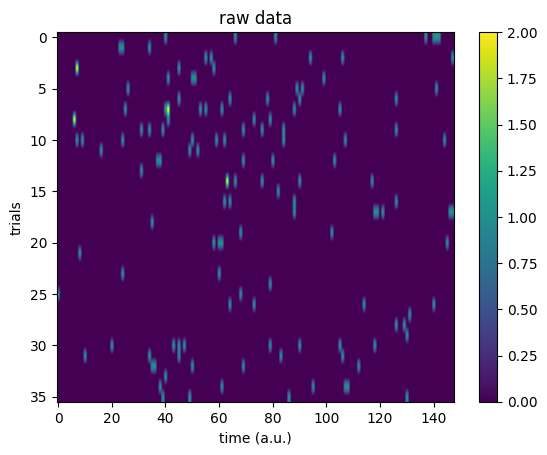

In [3]:
# Generate data using helper function.

# Plot data.
plt.imshow(np.squeeze(data[:,:,10]), aspect='auto')
plt.title('raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

 ### Fit model, plot reconstruction error over time.
 
Since the data is very noisy, we'll add a roughness penalty to the model template to damp down high-frequency noise. This isn't entirely necessary for this simple example, but can be useful in real datasets.

Loss: 0.03: 100%|██████████| 20/20 [00:00<00:00, 36.03it/s]


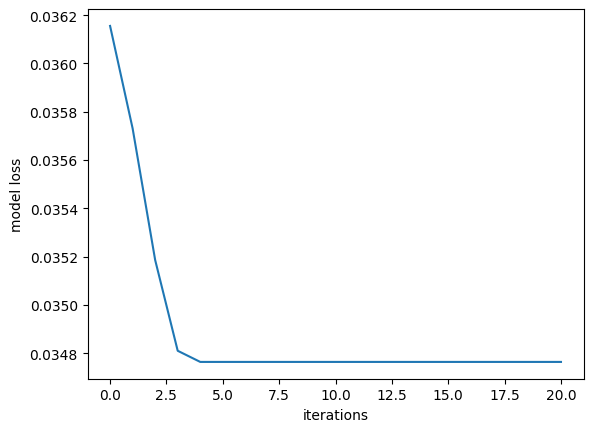

In [4]:
from affinewarp import ShiftWarping

# Create the model. Add a roughness penalty to the model template.
model = ShiftWarping(maxlag=.3, smoothness_reg_scale=10.)

# NOTE : you can also use PiecewiseWarping with `n_knots` parameter set to -1.
#
#  >> model = PiecewiseWarping(n_knots=-1, smoothness_reg_scale=10.)

# Fit the model.
model.fit(data, iterations=20)

# Plot model learning curve.
plt.plot(model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('model loss');

### Plot the model estimate of the data

Note that the model estimate is denoised compared to the raw data we plotted above.

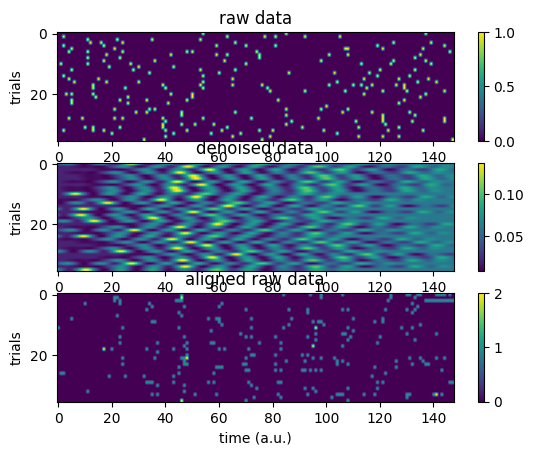

In [ ]:
# 2*1 の subplotを作成
plt.subplot(3, 1, 1)

idx = 12
# 1番目のsubplotに描画
plt.imshow(np.squeeze(data[:,:,idx]), aspect='auto')
plt.title('raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

# 2番目のsubplotに描画
plt.subplot(3, 1, 2)
plt.imshow(model.predict()[:,:,idx-1:idx].squeeze(), aspect='auto')
plt.title('denoised data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

# 3番目のsubplotに描画
plt.subplot(3, 1, 3)
plt.imshow(model.transform(data)[:,:,idx-1:idx].squeeze(), aspect='auto')
plt.title('aligned raw data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

### Apply the learned warping functions to lfp

In [ ]:

fname = r"H:\KenjiLinux150210\BuzsakiLabCopy\unit2\ec013.43\ec013.773\ec013.773.eeg"
numch = 65
chselect = 12
lfp = m2p.read_single_ch(fname, numch, chselect)

In [8]:
ThetaPhase, Amp, Tot = m2p.theta_phase(lfp, FreqRange=[4, 10], FilterOrd=4, SampleRate=1250)

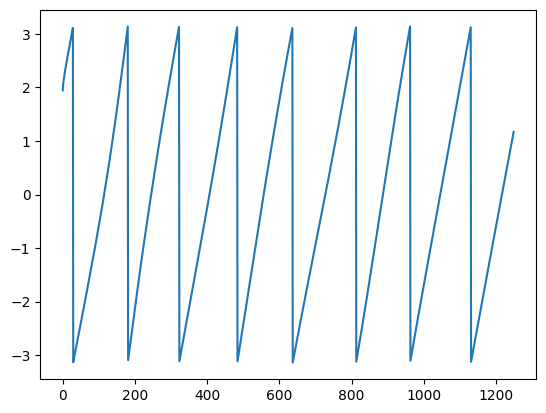

### We can also plot the model template across all trials

This corresponds to the model's estimate in the warped/aligned temporal domain.

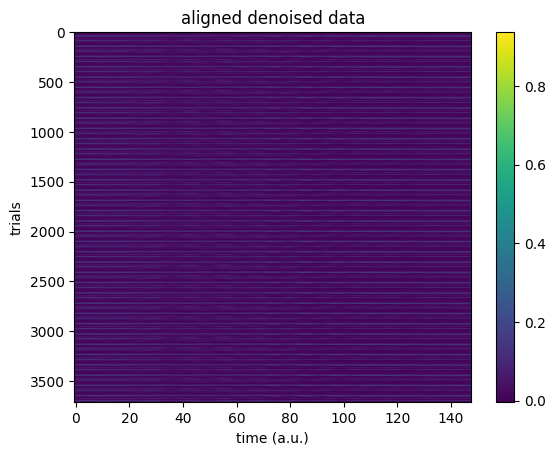

In [80]:
plt.imshow(np.tile(model.template, (1, data.shape[0])).T, aspect='auto')
plt.title('aligned denoised data'), plt.xlabel('time (a.u.)'), plt.ylabel('trials')
plt.colorbar();

### Simply trial-averaging over the raw data gives a smeared-out PSTH.

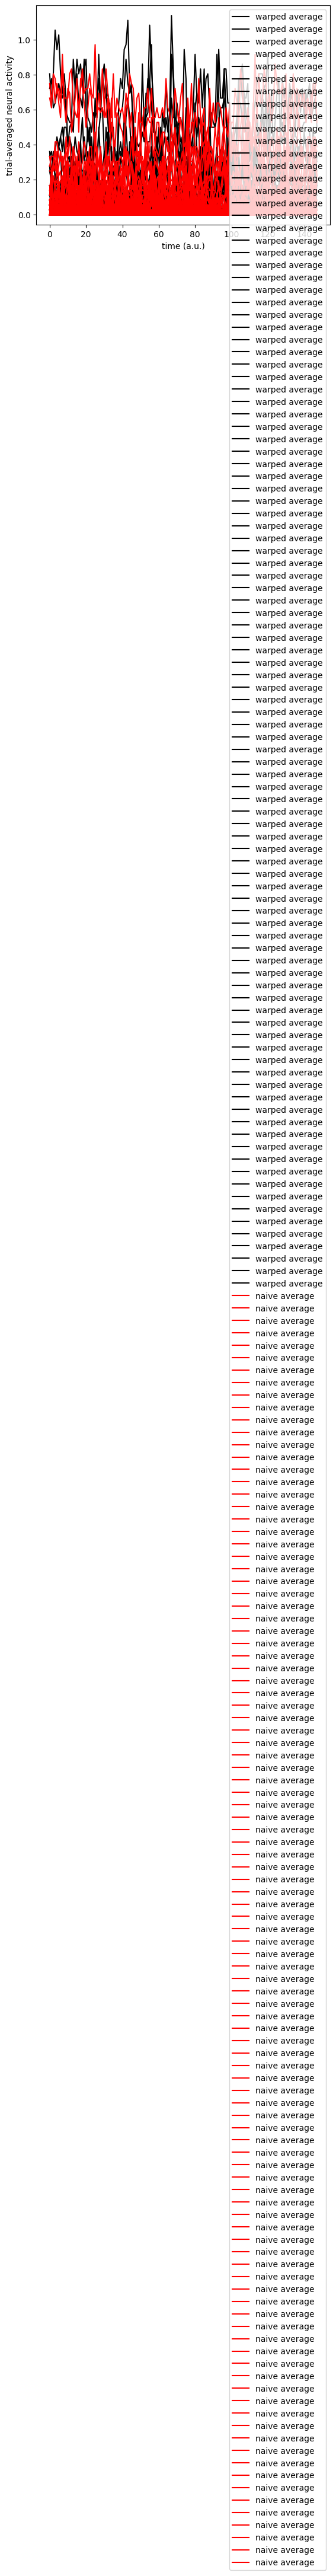

In [81]:
plt.plot(model.transform(data).mean(axis=0), color='k', label='warped average')
plt.plot(data.mean(axis=0), color='r', label='naive average')
plt.ylabel('trial-averaged neural activity'), plt.xlabel('time (a.u.)'), plt.legend();

### Plot the model template vs the warped trial average

The model template is smoother because we added a roughness penalty (not present when we average over the aligned data).

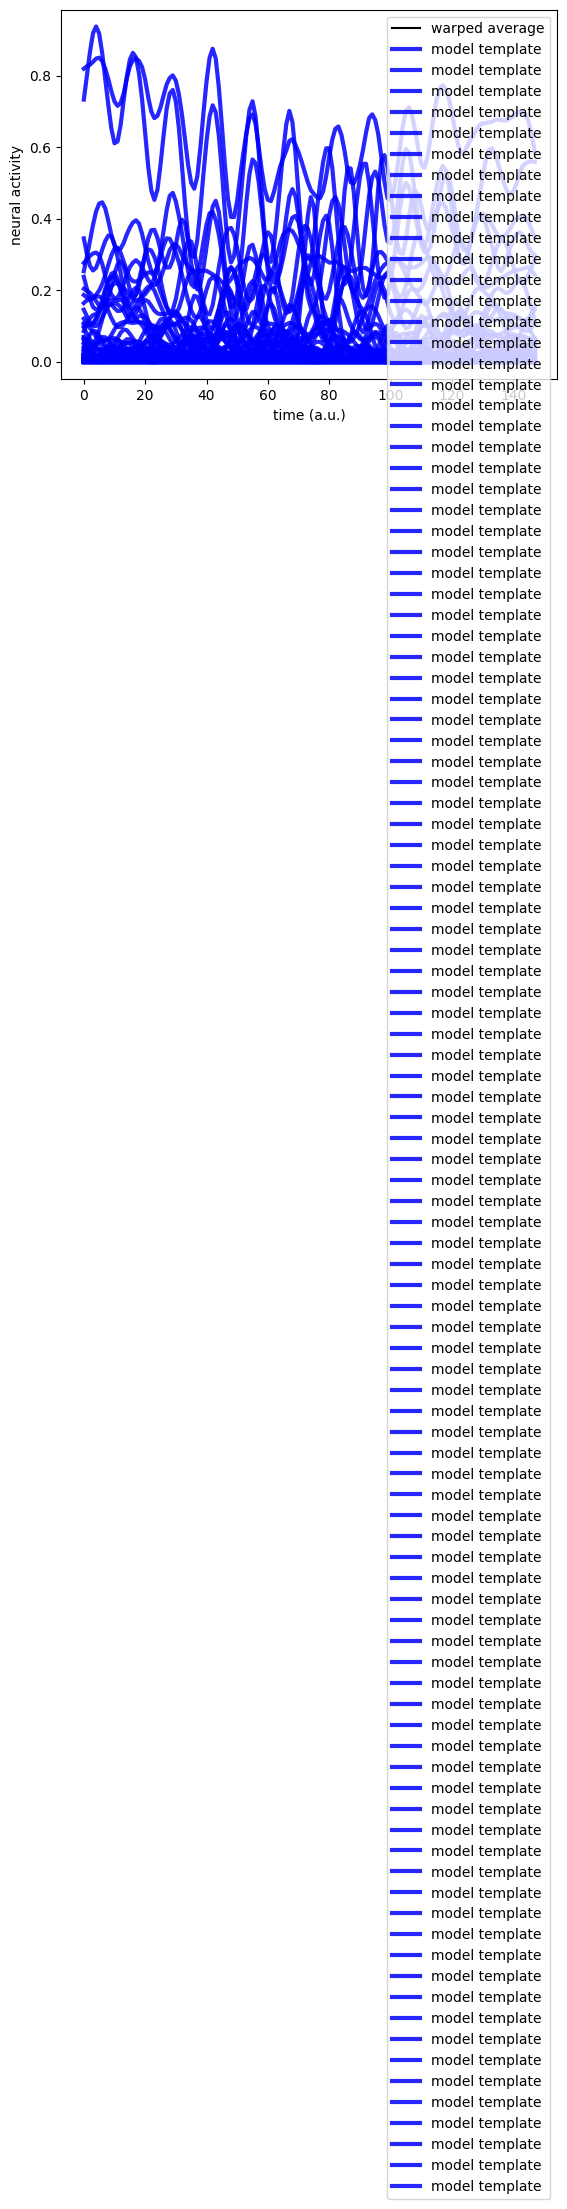

In [82]:
plt.plot(model.transform(data)[:,:,0].mean(axis=0), color='k', label='warped average')
plt.plot(model.template, '-', color='b', label='model template', lw=3, alpha=.85)
plt.ylabel('neural activity'), plt.xlabel('time (a.u.)'), plt.legend();

# A note on cross-validation

In this basic example, we only considered a single neuron over multiple trials. In general, it is advisable to apply these methods to larger populations of simultaneously recorded neurons. This enables various cross-validation schemes---e.g. by fitting the model to a subset of neurons and visualizing the aligned activity of held out cells.